In [1]:
from kan import KAN
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 


device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

In [ ]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

# Dataset Args
n_classes = 2 #2**2
m = 10
n_epochs = 5_000
hidden = [5]*3
architecture = [2] + hidden + [n_classes]

print(architecture)

args_dict = {
    'seed': 0,
    'base_fun': "silu",
    'kan_architecture': architecture,
    'grid': 5,
    'k': 3,
    'bounds': (-1,1),
    'learning_rate': 1e-3,
}
args = Args(**args_dict)

[2, 5, 5, 5, 2]


In [3]:
architecture_mlp = [architecture[i]*architecture[i+1]*args.grid for i in range(len(architecture)-1)]
architecture_mlp[0] = architecture[0]
architecture_mlp[-1] = architecture[-1]
print(architecture_mlp)

[2, 125, 125, 2]


In [4]:
def spiral_data(n_samples=1000, n_classes=3, noise=0.5, seed=0, device="cpu"):
    np.random.seed(seed)
    X = []
    y = []
    samples_per_class = n_samples // n_classes
    for class_num in range(n_classes):
        ix = np.linspace(0, 1, samples_per_class)
        r = ix
        t = class_num * 4 + ix * 4 * np.pi + np.random.randn(samples_per_class) * noise
        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        X.append(np.c_[x1, x2])
        y.append(np.full(samples_per_class, class_num))
    X = np.concatenate(X)
    y = np.concatenate(y)
    # Shuffle the data
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    # Split into train/test (50/50)
    split = len(X) // 2
    train_input, test_input = X[:split], X[split:]
    train_label, test_label = y[:split], y[split:]
    dtype = torch.get_default_dtype()
    dataset = {}
    dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
    dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
    dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)
    return dataset

dataset = spiral_data(n_samples=1000, n_classes=n_classes, noise=0.0, seed=42, device=device)

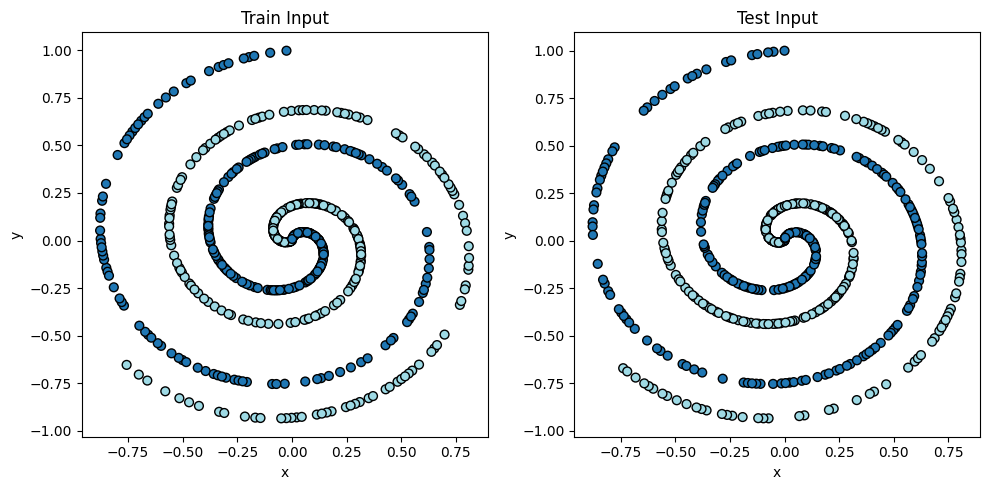

In [5]:

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot train input
axs[0].scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(),
               c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[0].set_title('Train Input')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot test input
axs[1].scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(),
               c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=40)
axs[1].set_title('Test Input')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()

In [6]:
# class ReLUMLP(nn.Module):
#     def __init__(self, n_hidden=32, n_classes=2, depth=3):
#         super().__init__()
#         layers = [nn.Linear(2, n_hidden), nn.ReLU()]
#         for _ in range(depth - 1):
#             layers.append(nn.Linear(n_hidden, n_hidden))
#             layers.append(nn.ReLU())
#         layers.append(nn.Linear(n_hidden, n_classes))
#         self.net = nn.Sequential(*layers)
#     def forward(self, x):
#         return self.net(x)

# mlp = ReLUMLP(n_hidden=hidden[0], n_classes=n_classes, depth=len(hidden)).to(device)
# print("MLP")
# print(mlp)

In [7]:
class ReLUMLP(nn.Module):
    def __init__(self, architecture):
        super().__init__()
        layers = []
        for i in range(len(architecture) - 2):
            layers.append(nn.Linear(architecture[i], architecture[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(architecture[-2], architecture[-1]))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

mlp = ReLUMLP(architecture).to(device)
print("MLP")
print(mlp)

MLP
ReLUMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=2, bias=True)
  )
)


# Normal MLP & KAN Training

In [8]:
import torch.nn.functional as F

def train_model(model, optimizer, dataset, n_epochs=100, log_interval=10):
    train_input = dataset['train_input']
    train_label = dataset['train_label']
    test_input = dataset['test_input']
    test_label = dataset['test_label']

    train_accs, test_accs, train_losses, test_losses = [], [], [], []

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_input)
        loss = F.cross_entropy(output, train_label)
        loss.backward()
        optimizer.step()

        # Logging
        model.eval()
        with torch.no_grad():
            train_pred = model(train_input).argmax(dim=1)
            test_pred = model(test_input).argmax(dim=1)
            train_acc = (train_pred == train_label).float().mean().item()
            test_acc = (test_pred == test_label).float().mean().item()
            train_loss = F.cross_entropy(model(train_input), train_label).item()
            test_loss = F.cross_entropy(model(test_input), test_label).item()
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        if (epoch+1) % log_interval == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | Train Loss: {train_loss:.3f} | Test Loss: {test_loss:.3f}")

    return {
        'train_accs': train_accs,
        'test_accs': test_accs,
        'train_losses': train_losses,
        'test_losses': test_losses
    }


In [9]:
# Train MLP
mlp_opt = torch.optim.Adam(mlp.parameters(), lr=args.learning_rate)
mlp_logs = train_model(mlp, mlp_opt, dataset, n_epochs=n_epochs)

Epoch 1/5000 | Train Acc: 0.496 | Test Acc: 0.504 | Train Loss: 0.698 | Test Loss: 0.696
Epoch 10/5000 | Train Acc: 0.504 | Test Acc: 0.496 | Train Loss: 0.693 | Test Loss: 0.694
Epoch 20/5000 | Train Acc: 0.548 | Test Acc: 0.522 | Train Loss: 0.691 | Test Loss: 0.692
Epoch 30/5000 | Train Acc: 0.538 | Test Acc: 0.482 | Train Loss: 0.686 | Test Loss: 0.690
Epoch 40/5000 | Train Acc: 0.552 | Test Acc: 0.494 | Train Loss: 0.672 | Test Loss: 0.687
Epoch 50/5000 | Train Acc: 0.532 | Test Acc: 0.474 | Train Loss: 0.667 | Test Loss: 0.695
Epoch 60/5000 | Train Acc: 0.544 | Test Acc: 0.500 | Train Loss: 0.665 | Test Loss: 0.692
Epoch 70/5000 | Train Acc: 0.548 | Test Acc: 0.488 | Train Loss: 0.663 | Test Loss: 0.695
Epoch 80/5000 | Train Acc: 0.548 | Test Acc: 0.478 | Train Loss: 0.661 | Test Loss: 0.694
Epoch 90/5000 | Train Acc: 0.566 | Test Acc: 0.512 | Train Loss: 0.657 | Test Loss: 0.687
Epoch 100/5000 | Train Acc: 0.564 | Test Acc: 0.518 | Train Loss: 0.653 | Test Loss: 0.684
Epoch 110/

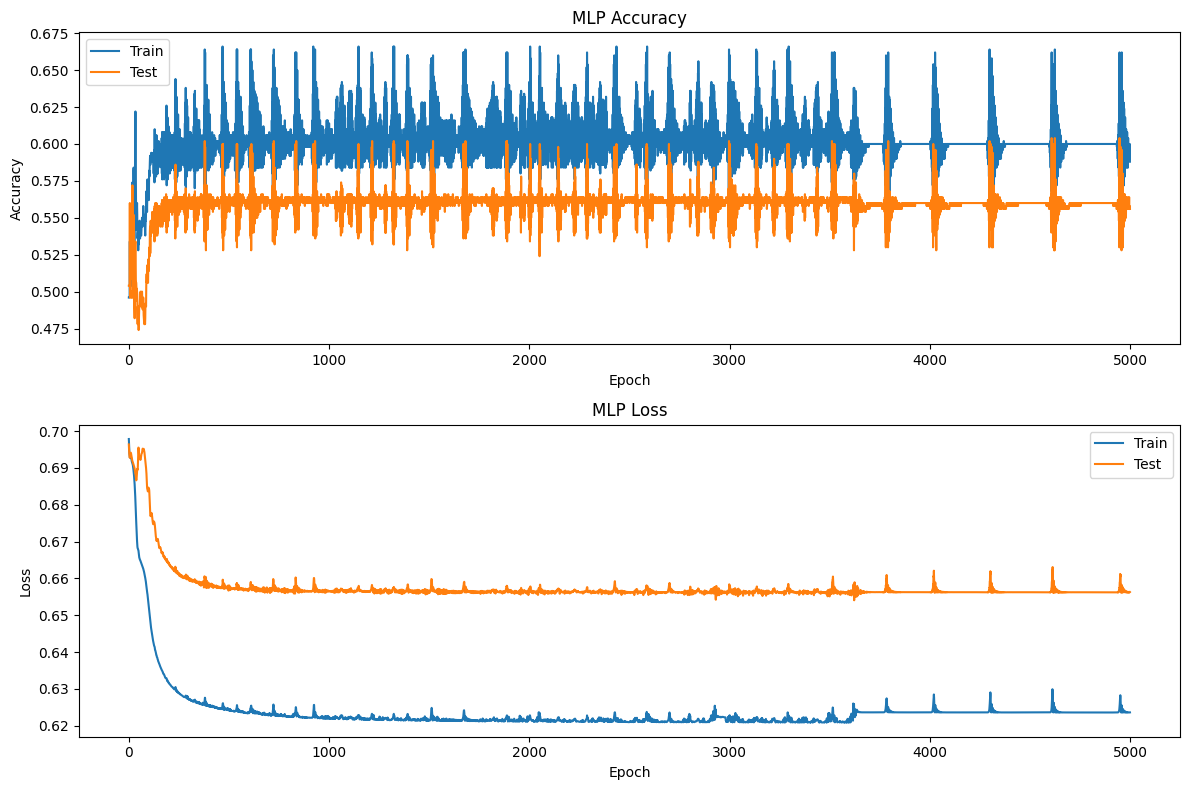

In [10]:

# Plotting
fig, axs_plot = plt.subplots(2, 1, figsize=(12, 8))

# KAN plots
axs_plot[0].plot(mlp_logs['train_accs'], label='Train')
axs_plot[0].plot(mlp_logs['test_accs'], label='Test')
axs_plot[0].set_title('MLP Accuracy')
axs_plot[0].set_xlabel('Epoch')
axs_plot[0].set_ylabel('Accuracy')
axs_plot[0].legend()

axs_plot[1].plot(mlp_logs['train_losses'], label='Train')
axs_plot[1].plot(mlp_logs['test_losses'], label='Test')
axs_plot[1].set_title('MLP Loss')
axs_plot[1].set_xlabel('Epoch')
axs_plot[1].set_ylabel('Loss')
axs_plot[1].legend()

plt.tight_layout()
plt.show()

In [11]:
# Create a mesh grid over the input space
xx, yy = np.meshgrid(
    np.linspace(-1.1 , 1.1, 300),
    np.linspace(-1.1 , 1.1, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.from_numpy(grid).type(dtype).to(device)


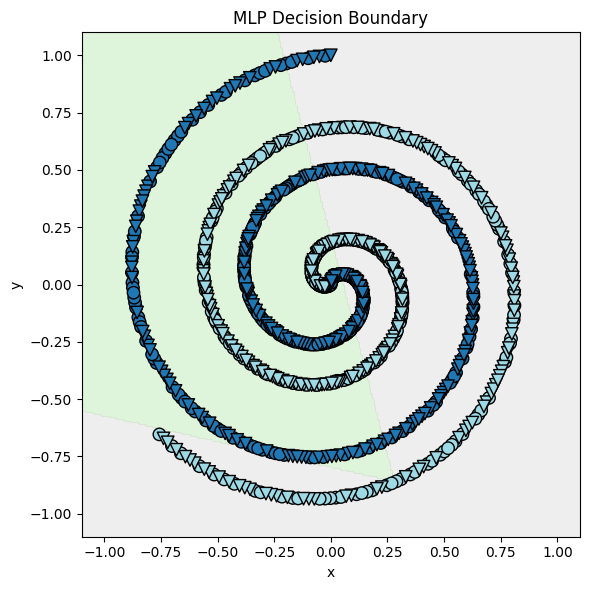

In [12]:
# Evaluate kan_layerwise on the grid
mlp.eval()
with torch.no_grad():
    mlp_pred = mlp(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, mlp_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
plt.scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(), 
            c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='o', label='Train Data (o)')
plt.scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(), 
            c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='v', label='Test Data (v)')
plt.title('MLP Decision Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [13]:
kan = KAN(
    width=args.kan_architecture,
    device=device,
    grid=args.grid, k=args.k, #seed=0,
    #init_mode='kaiming_in',
    base_fun=args.base_fun,
    )
print("KAN")
print(kan)

_ = kan(dataset['train_input'])

checkpoint directory created: ./model
saving model version 0.0
KAN
MultKAN(
  (act_fun): ModuleList(
    (0-3): 4 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-3): 4 x Symbolic_KANLayer()
  )
)


In [ ]:
# Train KAN
kan_opt = torch.optim.Adam(kan.parameters(), lr=args.learning_rate)
kan_logs = train_model(kan, kan_opt, dataset, n_epochs=n_epochs)

Epoch 1/5000 | Train Acc: 0.540 | Test Acc: 0.488 | Train Loss: 0.691 | Test Loss: 0.692
Epoch 10/5000 | Train Acc: 0.546 | Test Acc: 0.504 | Train Loss: 0.664 | Test Loss: 0.704
Epoch 20/5000 | Train Acc: 0.560 | Test Acc: 0.500 | Train Loss: 0.650 | Test Loss: 0.689
Epoch 30/5000 | Train Acc: 0.546 | Test Acc: 0.516 | Train Loss: 0.632 | Test Loss: 0.674
Epoch 40/5000 | Train Acc: 0.574 | Test Acc: 0.550 | Train Loss: 0.579 | Test Loss: 0.606
Epoch 50/5000 | Train Acc: 0.760 | Test Acc: 0.746 | Train Loss: 0.435 | Test Loss: 0.438
Epoch 60/5000 | Train Acc: 0.896 | Test Acc: 0.898 | Train Loss: 0.270 | Test Loss: 0.260
Epoch 70/5000 | Train Acc: 0.956 | Test Acc: 0.942 | Train Loss: 0.138 | Test Loss: 0.184


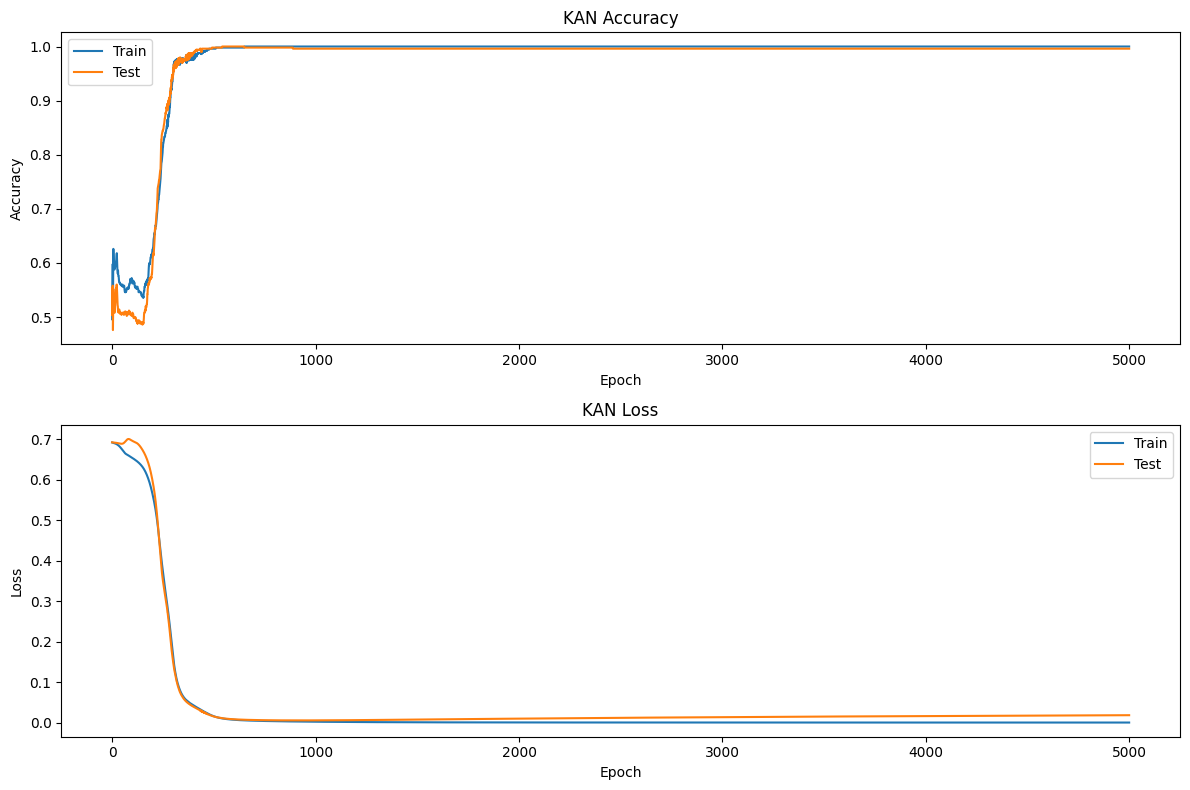

In [ ]:
# Plotting
fig, axs_plot = plt.subplots(2, 1, figsize=(12, 8))

# KAN plots
axs_plot[0].plot(kan_logs['train_accs'], label='Train')
axs_plot[0].plot(kan_logs['test_accs'], label='Test')
axs_plot[0].set_title('KAN Accuracy')
axs_plot[0].set_xlabel('Epoch')
axs_plot[0].set_ylabel('Accuracy')
axs_plot[0].legend()

axs_plot[1].plot(kan_logs['train_losses'], label='Train')
axs_plot[1].plot(kan_logs['test_losses'], label='Test')
axs_plot[1].set_title('KAN Loss')
axs_plot[1].set_xlabel('Epoch')
axs_plot[1].set_ylabel('Loss')
axs_plot[1].legend()

plt.tight_layout()
plt.show()

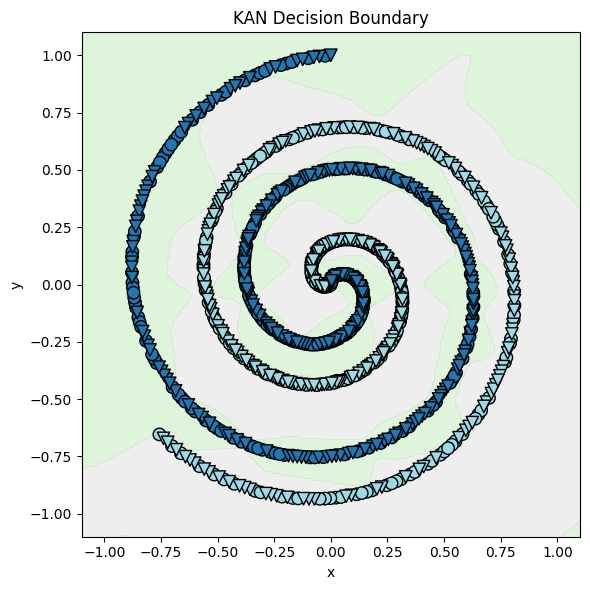

In [ ]:
# Evaluate kan_layerwise on the grid
kan.eval()
with torch.no_grad():
    kan_pred = kan(grid_tensor).argmax(dim=1).cpu().numpy().reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, kan_pred, alpha=0.3, levels=n_classes-1, cmap='tab20')
plt.scatter(dataset['train_input'][:, 0].cpu(), dataset['train_input'][:, 1].cpu(), 
            c=dataset['train_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='o', label='Train Data (o)')
plt.scatter(dataset['test_input'][:, 0].cpu(), dataset['test_input'][:, 1].cpu(), 
            c=dataset['test_label'].cpu(), cmap='tab20', edgecolor='k', s=80, marker='v', label='Test Data (v)')
plt.title('KAN Decision Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [ ]:
for i, preacts in enumerate(kan.spline_preacts):
    print(f"Layer {i}: Preactivation shape: {preacts.shape}")

Layer 0: Preactivation shape: torch.Size([90000, 5, 2])
Layer 1: Preactivation shape: torch.Size([90000, 5, 5])
Layer 2: Preactivation shape: torch.Size([90000, 5, 5])
Layer 3: Preactivation shape: torch.Size([90000, 2, 5])


Layer 1: 2 components for 90% variance, 2 components for 95% variance
Layer 2: 4 components for 90% variance, 4 components for 95% variance


Layer 3: 2 components for 90% variance, 2 components for 95% variance
Layer 4: 1 components for 90% variance, 1 components for 95% variance


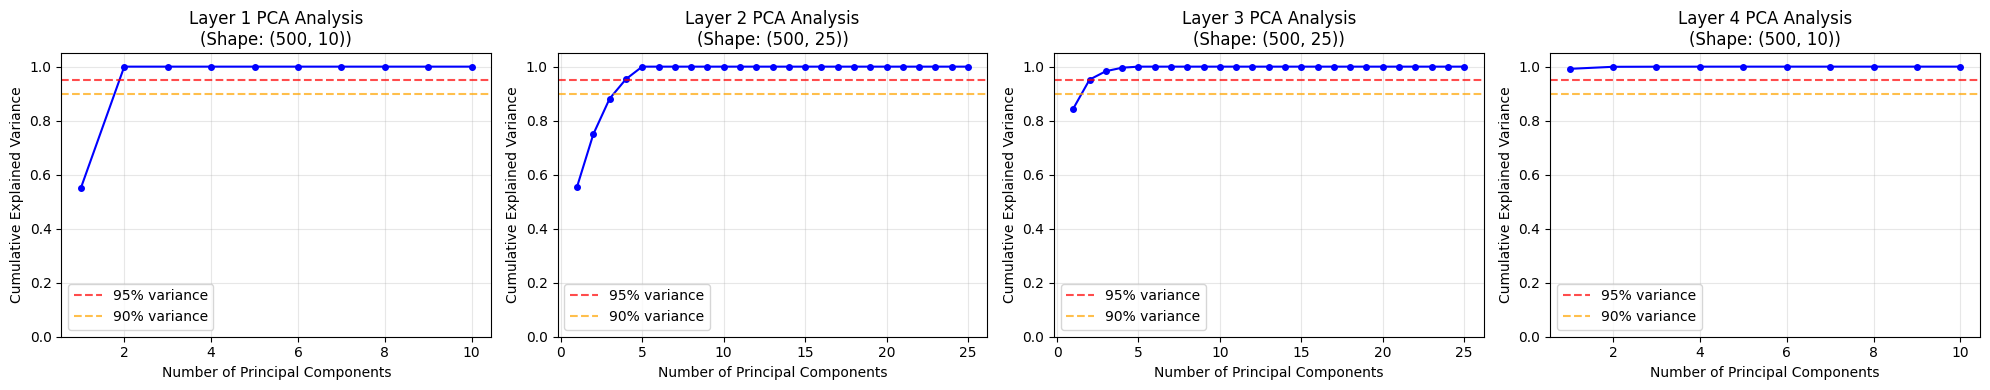

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Get activations for each layer by doing a forward pass
kan.eval()
with torch.no_grad():
    # Forward pass to populate spline_preacts
    _ = kan(dataset['train_input'])
    
    # Analyze each layer's activations
    n_layers = len(kan.spline_preacts)
    fig, axes = plt.subplots(1, n_layers, figsize=(5 * n_layers, 4))
    
    if n_layers == 1:
        axes = [axes]  # Make it iterable for single layer case
    
    for i, preacts in enumerate(kan.spline_preacts):
        # Convert to numpy and reshape if needed
        activations = preacts.cpu().numpy()
        
        # If activations are 3D (batch, input_dim, output_dim), reshape to 2D
        if len(activations.shape) == 3:
            batch_size, input_dim, output_dim = activations.shape
            activations = activations.reshape(batch_size, -1)
        
        # Perform PCA
        pca = PCA()
        pca.fit(activations)
        
        # Calculate cumulative explained variance ratio
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        
        # Plot
        axes[i].plot(range(1, len(cumvar) + 1), cumvar, 'bo-', markersize=4)
        axes[i].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% variance')
        axes[i].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% variance')
        axes[i].set_xlabel('Number of Principal Components')
        axes[i].set_ylabel('Cumulative Explained Variance')
        axes[i].set_title(f'Layer {i+1} PCA Analysis\n(Shape: {activations.shape})')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
        axes[i].set_ylim(0, 1.05)
        
        # Find number of components for 90% and 95% variance
        n_95 = np.argmax(cumvar >= 0.95) + 1
        n_90 = np.argmax(cumvar >= 0.90) + 1
        
        print(f"Layer {i+1}: {n_90} components for 90% variance, {n_95} components for 95% variance")
    
    plt.tight_layout()
    plt.show()

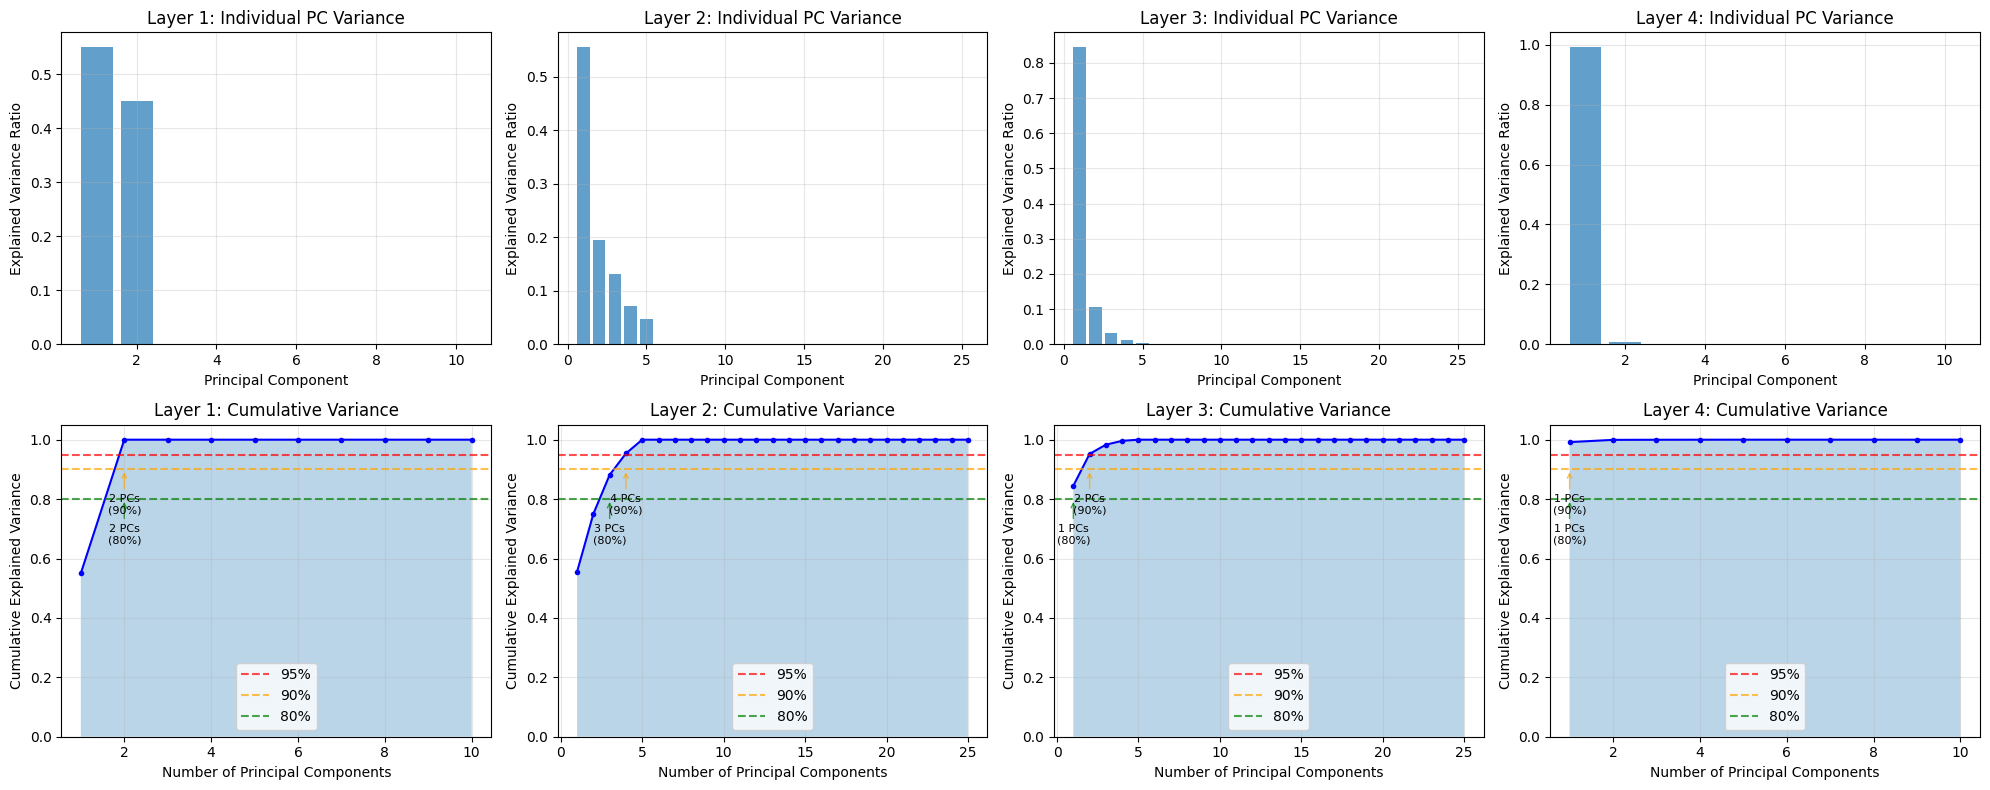

In [ ]:
# Create a more detailed analysis showing individual component contributions
fig, axes = plt.subplots(2, n_layers, figsize=(5 * n_layers, 8))

if n_layers == 1:
    axes = axes.reshape(2, 1)  # Make it 2D for single layer case

for i, preacts in enumerate(kan.spline_preacts):
    # Convert to numpy and reshape if needed
    activations = preacts.cpu().numpy()
    
    # If activations are 3D (batch, input_dim, output_dim), reshape to 2D
    if len(activations.shape) == 3:
        batch_size, input_dim, output_dim = activations.shape
        activations = activations.reshape(batch_size, -1)
    
    # Perform PCA
    pca = PCA()
    pca.fit(activations)
    
    # Plot individual component variance ratios
    axes[0, i].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                   pca.explained_variance_ratio_, alpha=0.7)
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_ylabel('Explained Variance Ratio')
    axes[0, i].set_title(f'Layer {i+1}: Individual PC Variance')
    axes[0, i].grid(True, alpha=0.3)
    
    # Plot cumulative variance with more detail
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    axes[1, i].plot(range(1, len(cumvar) + 1), cumvar, 'bo-', markersize=3)
    axes[1, i].fill_between(range(1, len(cumvar) + 1), cumvar, alpha=0.3)
    axes[1, i].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    axes[1, i].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90%')
    axes[1, i].axhline(y=0.80, color='green', linestyle='--', alpha=0.7, label='80%')
    axes[1, i].set_xlabel('Number of Principal Components')
    axes[1, i].set_ylabel('Cumulative Explained Variance')
    axes[1, i].set_title(f'Layer {i+1}: Cumulative Variance')
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].legend()
    axes[1, i].set_ylim(0, 1.05)
    
    # Add text annotations for key thresholds
    n_80 = np.argmax(cumvar >= 0.80) + 1
    n_90 = np.argmax(cumvar >= 0.90) + 1
    n_95 = np.argmax(cumvar >= 0.95) + 1
    
    axes[1, i].annotate(f'{n_80} PCs\n(80%)', 
                        xy=(n_80, 0.80), xytext=(n_80, 0.65),
                        arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                        ha='center', fontsize=8)
    axes[1, i].annotate(f'{n_90} PCs\n(90%)', 
                        xy=(n_90, 0.90), xytext=(n_90, 0.75),
                        arrowprops=dict(arrowstyle='->', color='orange', alpha=0.7),
                        ha='center', fontsize=8)

plt.tight_layout()
plt.show()

PCA Analysis Summary for KAN Layers:
  Layer Activation Shape  Total Components  PCs for 80%  PCs for 90%  PCs for 95%  PCs for 99% Top PC Variance Compression 90% Compression 95%
Layer 1        (500, 10)                10            2            2            2            2           0.550          20.00%          20.00%
Layer 2        (500, 25)                25            3            4            4            5           0.555          16.00%          16.00%
Layer 3        (500, 25)                25            1            2            2            4           0.845           8.00%           8.00%
Layer 4        (500, 10)                10            1            1            1            1           0.992          10.00%          10.00%


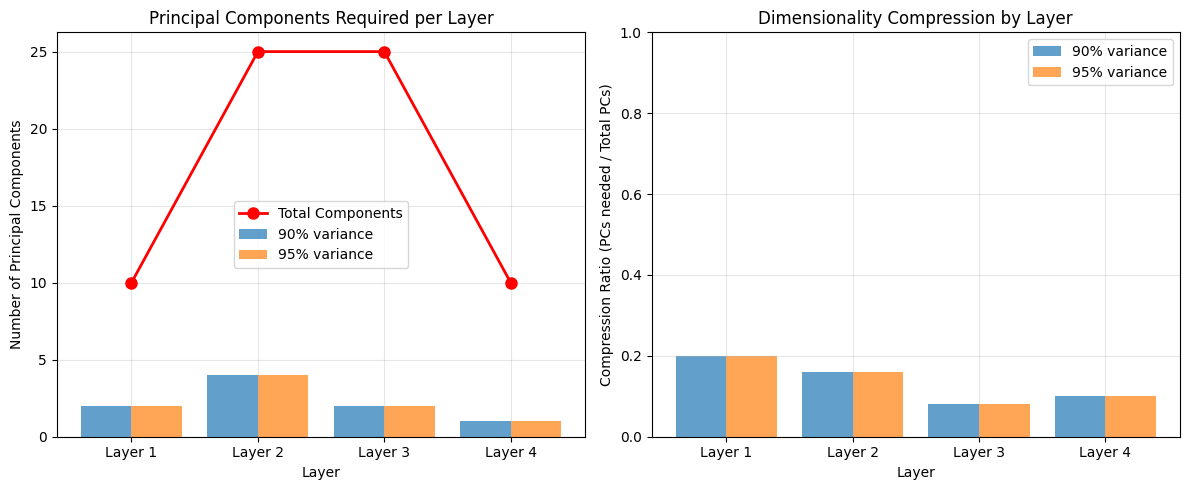

In [ ]:
# Create a summary table of PCA results
import pandas as pd

summary_data = []
for i, preacts in enumerate(kan.spline_preacts):
    # Convert to numpy and reshape if needed
    activations = preacts.cpu().numpy()
    
    # If activations are 3D (batch, input_dim, output_dim), reshape to 2D
    if len(activations.shape) == 3:
        batch_size, input_dim, output_dim = activations.shape
        activations = activations.reshape(batch_size, -1)
    
    # Perform PCA
    pca = PCA()
    pca.fit(activations)
    
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    
    # Calculate statistics
    n_total_components = len(pca.explained_variance_ratio_)
    n_80 = np.argmax(cumvar >= 0.80) + 1 if np.any(cumvar >= 0.80) else n_total_components
    n_90 = np.argmax(cumvar >= 0.90) + 1 if np.any(cumvar >= 0.90) else n_total_components
    n_95 = np.argmax(cumvar >= 0.95) + 1 if np.any(cumvar >= 0.95) else n_total_components
    n_99 = np.argmax(cumvar >= 0.99) + 1 if np.any(cumvar >= 0.99) else n_total_components
    
    # Top component contribution
    max_component_var = pca.explained_variance_ratio_[0]
    
    summary_data.append({
        'Layer': f'Layer {i+1}',
        'Activation Shape': f'{activations.shape}',
        'Total Components': n_total_components,
        'PCs for 80%': n_80,
        'PCs for 90%': n_90,
        'PCs for 95%': n_95,
        'PCs for 99%': n_99,
        'Top PC Variance': f'{max_component_var:.3f}',
        'Compression 90%': f'{n_90/n_total_components:.2%}',
        'Compression 95%': f'{n_95/n_total_components:.2%}'
    })

summary_df = pd.DataFrame(summary_data)
print("PCA Analysis Summary for KAN Layers:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Also create a visualization of the compression ratios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

layers = [f'Layer {i+1}' for i in range(len(kan.spline_preacts))]
pcs_90 = summary_df['PCs for 90%'].values
pcs_95 = summary_df['PCs for 95%'].values
total_pcs = summary_df['Total Components'].values

# Plot absolute number of components needed
ax1.bar([i-0.2 for i in range(len(layers))], pcs_90, 0.4, label='90% variance', alpha=0.7)
ax1.bar([i+0.2 for i in range(len(layers))], pcs_95, 0.4, label='95% variance', alpha=0.7)
ax1.plot(range(len(layers)), total_pcs, 'ro-', label='Total Components', linewidth=2, markersize=8)
ax1.set_xlabel('Layer')
ax1.set_ylabel('Number of Principal Components')
ax1.set_title('Principal Components Required per Layer')
ax1.set_xticks(range(len(layers)))
ax1.set_xticklabels(layers)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot compression ratios
compression_90 = pcs_90 / total_pcs
compression_95 = pcs_95 / total_pcs

ax2.bar([i-0.2 for i in range(len(layers))], compression_90, 0.4, label='90% variance', alpha=0.7)
ax2.bar([i+0.2 for i in range(len(layers))], compression_95, 0.4, label='95% variance', alpha=0.7)
ax2.set_xlabel('Layer')
ax2.set_ylabel('Compression Ratio (PCs needed / Total PCs)')
ax2.set_title('Dimensionality Compression by Layer')
ax2.set_xticks(range(len(layers)))
ax2.set_xticklabels(layers)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
# Function to capture activations from MLP layers
class ActivationCapture:
    def __init__(self, model):
        self.activations = []
        self.hooks = []
        self.model = model
        
    def register_hooks(self):
        """Register forward hooks on ReLU layers to capture activations"""
        def hook_fn(module, input, output):
            # Store the activation after ReLU
            self.activations.append(output.detach().clone())
        
        # Find all ReLU layers and register hooks
        for name, module in self.model.named_modules():
            if isinstance(module, nn.ReLU):
                hook = module.register_forward_hook(hook_fn)
                self.hooks.append(hook)
    
    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def clear_activations(self):
        """Clear stored activations"""
        self.activations = []
    
    def capture_activations(self, input_data):
        """Capture activations for given input data"""
        self.clear_activations()
        self.register_hooks()
        
        # Forward pass
        with torch.no_grad():
            _ = self.model(input_data)
        
        # Store the captured activations
        captured_activations = [act.cpu().numpy() for act in self.activations]
        
        # Clean up
        self.remove_hooks()
        self.clear_activations()
        
        return captured_activations

# Create activation capture for MLP
mlp_capture = ActivationCapture(mlp)
print("Created activation capture mechanism for MLP")
print(f"MLP architecture: {mlp}")

Created activation capture mechanism for MLP
MLP architecture: ReLUMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=2, bias=True)
  )
)


In [ ]:
# Capture MLP activations on training data
mlp.eval()
mlp_activations = mlp_capture.capture_activations(dataset['train_input'])

print(f"Captured {len(mlp_activations)} activation layers from MLP")
for i, activation in enumerate(mlp_activations):
    print(f"Layer {i+1}: Activation shape: {activation.shape}")
    
print(f"\nNote: MLP has {len(mlp_activations)} ReLU layers, so we captured {len(mlp_activations)} activation sets")

Captured 3 activation layers from MLP
Layer 1: Activation shape: (500, 5)
Layer 2: Activation shape: (500, 5)
Layer 3: Activation shape: (500, 5)

Note: MLP has 3 ReLU layers, so we captured 3 activation sets


# MLP PCA Analysis

MLP Layer 1: 2 components for 90% variance, 2 components for 95% variance
MLP Layer 2: 1 components for 90% variance, 2 components for 95% variance
MLP Layer 3: 1 components for 90% variance, 1 components for 95% variance


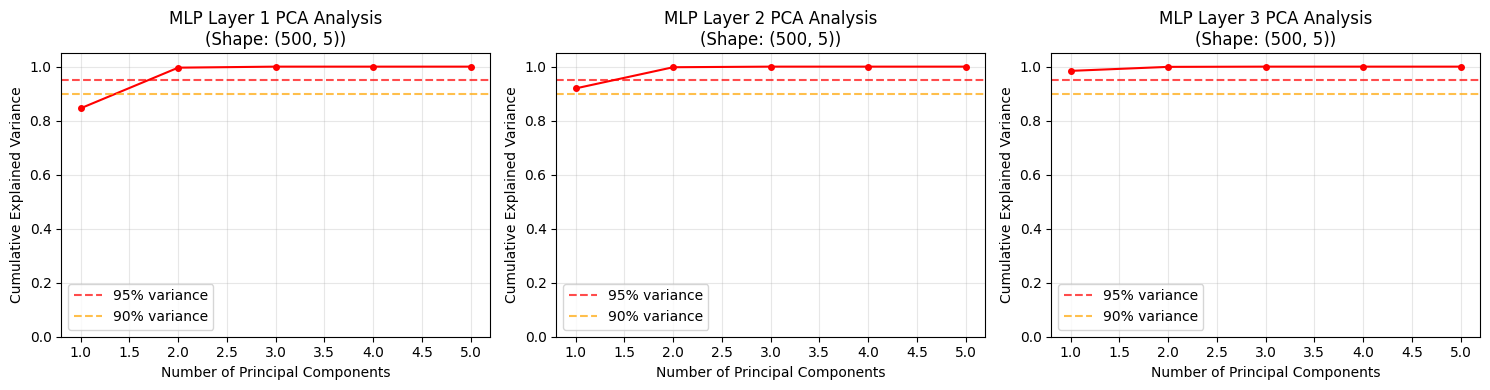

In [ ]:
# Perform PCA analysis on MLP activations (similar to KAN analysis)
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Analyze each layer's activations for MLP
n_layers = len(mlp_activations)
fig, axes = plt.subplots(1, n_layers, figsize=(5 * n_layers, 4))

if n_layers == 1:
    axes = [axes]  # Make it iterable for single layer case

for i, activations in enumerate(mlp_activations):
    # activations are already numpy arrays from our capture mechanism
    
    # Perform PCA
    pca = PCA()
    pca.fit(activations)
    
    # Calculate cumulative explained variance ratio
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    
    # Plot
    axes[i].plot(range(1, len(cumvar) + 1), cumvar, 'ro-', markersize=4)
    axes[i].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95% variance')
    axes[i].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90% variance')
    axes[i].set_xlabel('Number of Principal Components')
    axes[i].set_ylabel('Cumulative Explained Variance')
    axes[i].set_title(f'MLP Layer {i+1} PCA Analysis\n(Shape: {activations.shape})')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()
    axes[i].set_ylim(0, 1.05)
    
    # Find number of components for 90% and 95% variance
    n_95 = np.argmax(cumvar >= 0.95) + 1 if np.any(cumvar >= 0.95) else len(cumvar)
    n_90 = np.argmax(cumvar >= 0.90) + 1 if np.any(cumvar >= 0.90) else len(cumvar)
    
    print(f"MLP Layer {i+1}: {n_90} components for 90% variance, {n_95} components for 95% variance")

plt.tight_layout()
plt.show()

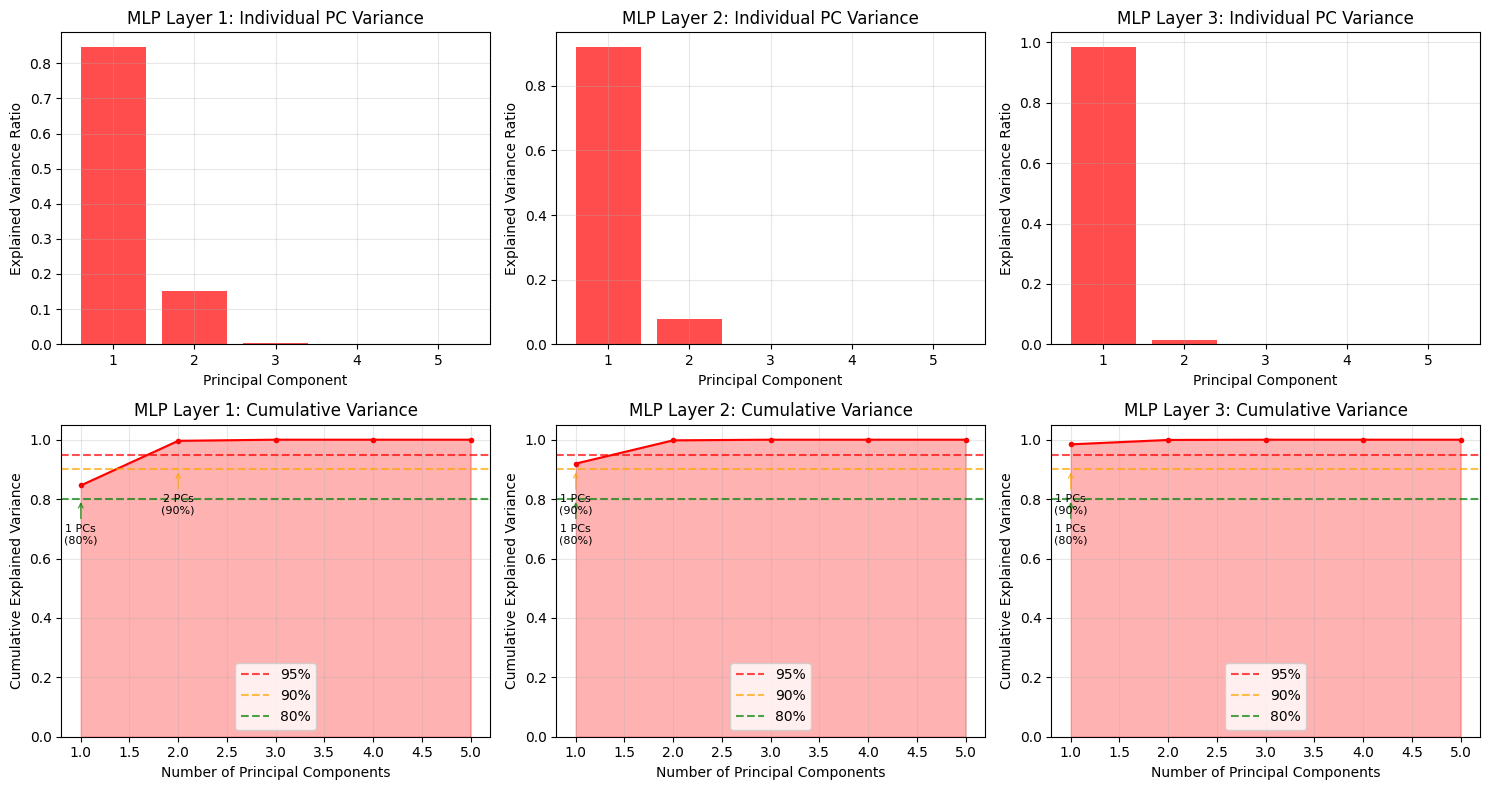

In [ ]:
# Create a more detailed analysis for MLP showing individual component contributions
fig, axes = plt.subplots(2, n_layers, figsize=(5 * n_layers, 8))

if n_layers == 1:
    axes = axes.reshape(2, 1)  # Make it 2D for single layer case

for i, activations in enumerate(mlp_activations):
    # Perform PCA
    pca = PCA()
    pca.fit(activations)
    
    # Plot individual component variance ratios
    axes[0, i].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
                   pca.explained_variance_ratio_, alpha=0.7, color='red')
    axes[0, i].set_xlabel('Principal Component')
    axes[0, i].set_ylabel('Explained Variance Ratio')
    axes[0, i].set_title(f'MLP Layer {i+1}: Individual PC Variance')
    axes[0, i].grid(True, alpha=0.3)
    
    # Plot cumulative variance with more detail
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    axes[1, i].plot(range(1, len(cumvar) + 1), cumvar, 'ro-', markersize=3)
    axes[1, i].fill_between(range(1, len(cumvar) + 1), cumvar, alpha=0.3, color='red')
    axes[1, i].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    axes[1, i].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, label='90%')
    axes[1, i].axhline(y=0.80, color='green', linestyle='--', alpha=0.7, label='80%')
    axes[1, i].set_xlabel('Number of Principal Components')
    axes[1, i].set_ylabel('Cumulative Explained Variance')
    axes[1, i].set_title(f'MLP Layer {i+1}: Cumulative Variance')
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].legend()
    axes[1, i].set_ylim(0, 1.05)
    
    # Add text annotations for key thresholds
    n_80 = np.argmax(cumvar >= 0.80) + 1 if np.any(cumvar >= 0.80) else len(cumvar)
    n_90 = np.argmax(cumvar >= 0.90) + 1 if np.any(cumvar >= 0.90) else len(cumvar)
    n_95 = np.argmax(cumvar >= 0.95) + 1 if np.any(cumvar >= 0.95) else len(cumvar)
    
    axes[1, i].annotate(f'{n_80} PCs\n(80%)', 
                        xy=(n_80, 0.80), xytext=(n_80, 0.65),
                        arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                        ha='center', fontsize=8)
    axes[1, i].annotate(f'{n_90} PCs\n(90%)', 
                        xy=(n_90, 0.90), xytext=(n_90, 0.75),
                        arrowprops=dict(arrowstyle='->', color='orange', alpha=0.7),
                        ha='center', fontsize=8)

plt.tight_layout()
plt.show()

PCA Analysis Summary for MLP Layers:
  Layer Activation Shape  Total Components  PCs for 80%  PCs for 90%  PCs for 95%  PCs for 99% Top PC Variance Compression 90% Compression 95%
Layer 1         (500, 5)                 5            1            2            2            2           0.846          40.00%          40.00%
Layer 2         (500, 5)                 5            1            1            2            2           0.920          20.00%          40.00%
Layer 3         (500, 5)                 5            1            1            1            2           0.984          20.00%          20.00%


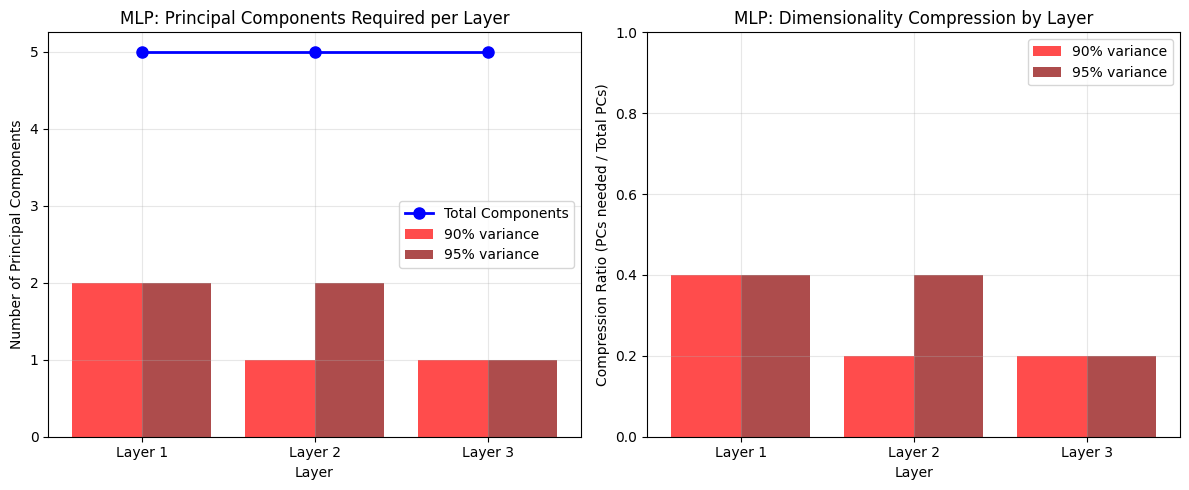

In [ ]:
# Create a summary table of MLP PCA results
import pandas as pd

mlp_summary_data = []
for i, activations in enumerate(mlp_activations):
    # Perform PCA
    pca = PCA()
    pca.fit(activations)
    
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    
    # Calculate statistics
    n_total_components = len(pca.explained_variance_ratio_)
    n_80 = np.argmax(cumvar >= 0.80) + 1 if np.any(cumvar >= 0.80) else n_total_components
    n_90 = np.argmax(cumvar >= 0.90) + 1 if np.any(cumvar >= 0.90) else n_total_components
    n_95 = np.argmax(cumvar >= 0.95) + 1 if np.any(cumvar >= 0.95) else n_total_components
    n_99 = np.argmax(cumvar >= 0.99) + 1 if np.any(cumvar >= 0.99) else n_total_components
    
    # Top component contribution
    max_component_var = pca.explained_variance_ratio_[0]
    
    mlp_summary_data.append({
        'Layer': f'Layer {i+1}',
        'Activation Shape': f'{activations.shape}',
        'Total Components': n_total_components,
        'PCs for 80%': n_80,
        'PCs for 90%': n_90,
        'PCs for 95%': n_95,
        'PCs for 99%': n_99,
        'Top PC Variance': f'{max_component_var:.3f}',
        'Compression 90%': f'{n_90/n_total_components:.2%}',
        'Compression 95%': f'{n_95/n_total_components:.2%}'
    })

mlp_summary_df = pd.DataFrame(mlp_summary_data)
print("PCA Analysis Summary for MLP Layers:")
print("=" * 80)
print(mlp_summary_df.to_string(index=False))

# Also create a visualization of the compression ratios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

layers = [f'Layer {i+1}' for i in range(len(mlp_activations))]
pcs_90 = mlp_summary_df['PCs for 90%'].values
pcs_95 = mlp_summary_df['PCs for 95%'].values
total_pcs = mlp_summary_df['Total Components'].values

# Plot absolute number of components needed
ax1.bar([i-0.2 for i in range(len(layers))], pcs_90, 0.4, label='90% variance', alpha=0.7, color='red')
ax1.bar([i+0.2 for i in range(len(layers))], pcs_95, 0.4, label='95% variance', alpha=0.7, color='darkred')
ax1.plot(range(len(layers)), total_pcs, 'bo-', label='Total Components', linewidth=2, markersize=8)
ax1.set_xlabel('Layer')
ax1.set_ylabel('Number of Principal Components')
ax1.set_title('MLP: Principal Components Required per Layer')
ax1.set_xticks(range(len(layers)))
ax1.set_xticklabels(layers)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot compression ratios
compression_90 = pcs_90 / total_pcs
compression_95 = pcs_95 / total_pcs

ax2.bar([i-0.2 for i in range(len(layers))], compression_90, 0.4, label='90% variance', alpha=0.7, color='red')
ax2.bar([i+0.2 for i in range(len(layers))], compression_95, 0.4, label='95% variance', alpha=0.7, color='darkred')
ax2.set_xlabel('Layer')
ax2.set_ylabel('Compression Ratio (PCs needed / Total PCs)')
ax2.set_title('MLP: Dimensionality Compression by Layer')
ax2.set_xticks(range(len(layers)))
ax2.set_xticklabels(layers)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Comparative Analysis: MLP vs KAN

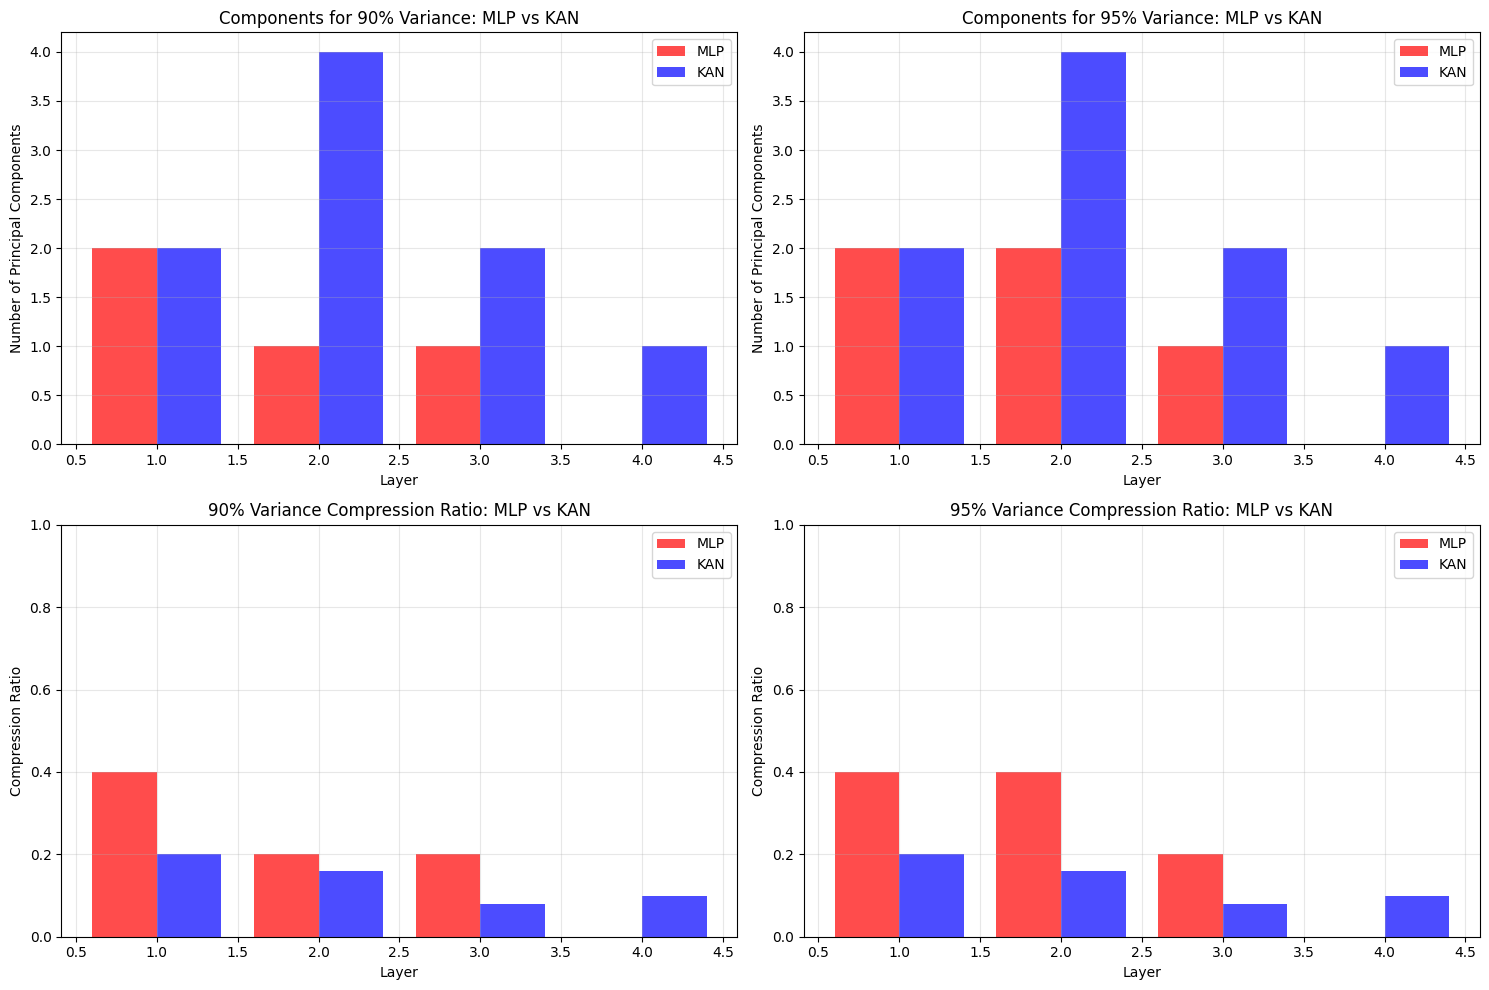

In [ ]:
# Comparative analysis between MLP and KAN PCA results

# First, let's get the KAN PCA data to compare
kan.eval()
with torch.no_grad():
    # Forward pass to populate spline_preacts
    _ = kan(dataset['train_input'])
    
    kan_summary_data = []
    for i, preacts in enumerate(kan.spline_preacts):
        # Convert to numpy and reshape if needed
        activations = preacts.cpu().numpy()
        
        # If activations are 3D (batch, input_dim, output_dim), reshape to 2D
        if len(activations.shape) == 3:
            batch_size, input_dim, output_dim = activations.shape
            activations = activations.reshape(batch_size, -1)
        
        # Perform PCA
        pca = PCA()
        pca.fit(activations)
        
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        
        # Calculate statistics
        n_total_components = len(pca.explained_variance_ratio_)
        n_80 = np.argmax(cumvar >= 0.80) + 1 if np.any(cumvar >= 0.80) else n_total_components
        n_90 = np.argmax(cumvar >= 0.90) + 1 if np.any(cumvar >= 0.90) else n_total_components
        n_95 = np.argmax(cumvar >= 0.95) + 1 if np.any(cumvar >= 0.95) else n_total_components
        n_99 = np.argmax(cumvar >= 0.99) + 1 if np.any(cumvar >= 0.99) else n_total_components
        
        # Top component contribution
        max_component_var = pca.explained_variance_ratio_[0]
        
        kan_summary_data.append({
            'Layer': i+1,
            'Total_Components': n_total_components,
            'PCs_90': n_90,
            'PCs_95': n_95,
            'Top_PC_Variance': max_component_var,
            'Compression_90': n_90/n_total_components,
            'Compression_95': n_95/n_total_components
        })

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Prepare data for comparison
max_layers = max(len(mlp_summary_data), len(kan_summary_data))
mlp_layers = list(range(1, len(mlp_summary_data) + 1))
kan_layers = list(range(1, len(kan_summary_data) + 1))

# Extract data for plotting
mlp_pcs_90 = [item['PCs for 90%'] for item in mlp_summary_data]
mlp_pcs_95 = [item['PCs for 95%'] for item in mlp_summary_data]
mlp_compression_90 = [float(item['Compression 90%'].rstrip('%')) / 100 for item in mlp_summary_data]
mlp_compression_95 = [float(item['Compression 95%'].rstrip('%')) / 100 for item in mlp_summary_data]

kan_pcs_90 = [item['PCs_90'] for item in kan_summary_data]
kan_pcs_95 = [item['PCs_95'] for item in kan_summary_data]
kan_compression_90 = [item['Compression_90'] for item in kan_summary_data]
kan_compression_95 = [item['Compression_95'] for item in kan_summary_data]

# Plot 1: Number of components needed (90% variance)
axes[0, 0].bar([x - 0.2 for x in mlp_layers], mlp_pcs_90, 0.4, label='MLP', alpha=0.7, color='red')
axes[0, 0].bar([x + 0.2 for x in kan_layers], kan_pcs_90, 0.4, label='KAN', alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Layer')
axes[0, 0].set_ylabel('Number of Principal Components')
axes[0, 0].set_title('Components for 90% Variance: MLP vs KAN')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Number of components needed (95% variance)
axes[0, 1].bar([x - 0.2 for x in mlp_layers], mlp_pcs_95, 0.4, label='MLP', alpha=0.7, color='red')
axes[0, 1].bar([x + 0.2 for x in kan_layers], kan_pcs_95, 0.4, label='KAN', alpha=0.7, color='blue')
axes[0, 1].set_xlabel('Layer')
axes[0, 1].set_ylabel('Number of Principal Components')
axes[0, 1].set_title('Components for 95% Variance: MLP vs KAN')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Compression ratios (90% variance)
axes[1, 0].bar([x - 0.2 for x in mlp_layers], mlp_compression_90, 0.4, label='MLP', alpha=0.7, color='red')
axes[1, 0].bar([x + 0.2 for x in kan_layers], kan_compression_90, 0.4, label='KAN', alpha=0.7, color='blue')
axes[1, 0].set_xlabel('Layer')
axes[1, 0].set_ylabel('Compression Ratio')
axes[1, 0].set_title('90% Variance Compression Ratio: MLP vs KAN')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 1)

# Plot 4: Compression ratios (95% variance)
axes[1, 1].bar([x - 0.2 for x in mlp_layers], mlp_compression_95, 0.4, label='MLP', alpha=0.7, color='red')
axes[1, 1].bar([x + 0.2 for x in kan_layers], kan_compression_95, 0.4, label='KAN', alpha=0.7, color='blue')
axes[1, 1].set_xlabel('Layer')
axes[1, 1].set_ylabel('Compression Ratio')
axes[1, 1].set_title('95% Variance Compression Ratio: MLP vs KAN')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
# Create a detailed comparison table
print("DETAILED COMPARISON: MLP vs KAN PCA Analysis")
print("=" * 90)
print("\nMLP Results:")
print("-" * 45)
print(mlp_summary_df.to_string(index=False))

print("\nKAN Results:")
print("-" * 45)
kan_summary_df = pd.DataFrame(kan_summary_data)
kan_summary_df_display = pd.DataFrame({
    'Layer': [f'Layer {i+1}' for i in range(len(kan_summary_data))],
    'Total Components': [item['Total_Components'] for item in kan_summary_data],
    'PCs for 90%': [item['PCs_90'] for item in kan_summary_data],
    'PCs for 95%': [item['PCs_95'] for item in kan_summary_data],
    'Top PC Variance': [f"{item['Top_PC_Variance']:.3f}" for item in kan_summary_data],
    'Compression 90%': [f"{item['Compression_90']:.2%}" for item in kan_summary_data],
    'Compression 95%': [f"{item['Compression_95']:.2%}" for item in kan_summary_data]
})
print(kan_summary_df_display.to_string(index=False))

# Key insights
print("\nKEY INSIGHTS:")
print("=" * 50)

# Average compression ratios
mlp_avg_90 = np.mean(mlp_compression_90)
mlp_avg_95 = np.mean(mlp_compression_95)
kan_avg_90 = np.mean(kan_compression_90)
kan_avg_95 = np.mean(kan_compression_95)

print(f"Average Compression Ratios (90% variance):")
print(f"  MLP: {mlp_avg_90:.2%}")
print(f"  KAN: {kan_avg_90:.2%}")
print(f"Average Compression Ratios (95% variance):")
print(f"  MLP: {mlp_avg_95:.2%}")
print(f"  KAN: {kan_avg_95:.2%}")

# Model performance comparison
print(f"\nModel Performance Comparison:")
print(f"  MLP Final Test Accuracy: {mlp_logs['test_accs'][-1]:.3f}")
print(f"  KAN Final Test Accuracy: {kan_logs['test_accs'][-1]:.3f}")

# Dimensionality insights
total_mlp_dims = sum([item['Total Components'] for item in mlp_summary_data])
total_kan_dims = sum([item['Total_Components'] for item in kan_summary_data])
print(f"\nTotal Activation Dimensions:")
print(f"  MLP: {total_mlp_dims}")
print(f"  KAN: {total_kan_dims}")

effective_mlp_dims_90 = sum(mlp_pcs_90)
effective_kan_dims_90 = sum(kan_pcs_90)
print(f"Effective Dimensions (90% variance):")
print(f"  MLP: {effective_mlp_dims_90} ({effective_mlp_dims_90/total_mlp_dims:.2%} of total)")
print(f"  KAN: {effective_kan_dims_90} ({effective_kan_dims_90/total_kan_dims:.2%} of total)")

DETAILED COMPARISON: MLP vs KAN PCA Analysis

MLP Results:
---------------------------------------------
  Layer Activation Shape  Total Components  PCs for 80%  PCs for 90%  PCs for 95%  PCs for 99% Top PC Variance Compression 90% Compression 95%
Layer 1         (500, 5)                 5            1            2            2            2           0.846          40.00%          40.00%
Layer 2         (500, 5)                 5            1            1            2            2           0.920          20.00%          40.00%
Layer 3         (500, 5)                 5            1            1            1            2           0.984          20.00%          20.00%

KAN Results:
---------------------------------------------
  Layer  Total Components  PCs for 90%  PCs for 95% Top PC Variance Compression 90% Compression 95%
Layer 1                10            2            2           0.550          20.00%          20.00%
Layer 2                25            4            4           0